# MLP from scratch

*name* : mahyar jahani nasab


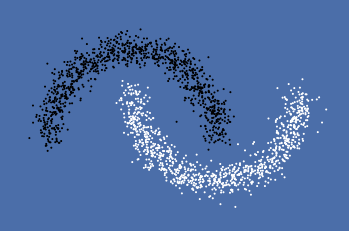

In [1]:
# all of these libraries are used for plotting
import numpy as np
import matplotlib.pyplot as plt

# Plot the dataset
def plot_data(ax, X, Y):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

from sklearn.datasets import make_moons
X, Y = make_moons(n_samples=2000, noise=0.1)

%matplotlib inline
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()

In [2]:
# Define the grid on which we will evaluate our classifier
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))

# plot the decision boundary of our classifier
def plot_decision_boundary(ax, X, Y, classifier):
    # forward pass on the grid, then convert to numpy for plotting
    Z = classifier.forward(to_forward)
    Z = Z.reshape(xx.shape)
    
    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z>0.5, cmap='Blues')
    
    # then plot the dataset
    plot_data(ax, X,Y)

## 2. MLP in numpy

Here you need to code your implementation of the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation and the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function).

In [8]:
class MyReLU(object):
    def forward(self, x):
        # the relu is y_i = max(0, x_i)
        # YOUR CODE HERE
        self.mask = (x <= 0) 
        out = x.copy() 
        out[self.mask] = 0 
        return out
        
    
    def backward(self, grad_output):
        # the gradient is 1 for the inputs that were above 0, 0 elsewhere
        # YOUR CODE HERE
        grad_output[self.mask] = 0 
        dx = grad_output 
        return dx
    
    def step(self, learning_rate):
        # no need to do anything here, since ReLU has no parameters
        # YOUR CODE HERE
        pass

class MySigmoid(object):
    def forward(self, x):
        # the sigmoid is y_i = 1./(1+exp(-x_i))
        # YOUR CODE HERE
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, grad_output):
        # the partial derivative is e^-x / (e^-x + 1)^2
        # YOUR CODE HERE
        dx = grad_output * self.out * (1 - self.out)
        return dx
    
    def step(self, learning_rate):
        # no need to do anything here since Sigmoid has no parameters
        # YOUR CODE HERE
        pass

In [9]:
test_relu = MyReLU()
test_relu.forward(X[10])

array([1.01897921, 0.27541175])

In [10]:
test_relu.backward(np.ones(2))

array([1., 1.])

In [11]:
test_sig = MySigmoid()

test_sig.forward(np.ones(1))

array([0.73105858])

In [12]:
test_sig.backward(np.ones(1))

array([0.19661193])

In [13]:
class MyLinear(object):
    def __init__(self, n_input, n_output):
        # initialize two random matrices for W and b (use np.random.randn)
        # YOUR CODE HERE
        self.W = np.random.randn(n_input, n_output) # initialize weight matrix with random values
        self.b = np.random.randn(n_output)
        self.x = None
        self.grad_W = None
        self.grad_b = None

    def forward(self, x):
        # save a copy of x, you'll need it for the backward
        # return Wx + b
        # YOUR CODE HERE
        self.x = x
        self.x_copy = x.copy() # save a copy of x for the backward pass
        return np.dot(x, self.W) + self.b

    def backward(self, grad_output):
        # y_i = \sum_j W_{i,j} x_j + b_i
        # d y_i / d W_{i, j} = x_j
        # d loss / d y_i = grad_output[i]
        # so d loss / d W_{i,j} = x_j * grad_output[i]  (by the chain rule)
        # YOUR CODE HERE
        self.y_i = np.sum(np.dot(self.x_copy, self.W), axis=0) + self.b
        
        # d y_i / d b_i = 1
        # d loss / d y_i = grad_output[i]
        # YOUR CODE HERE
        self.grad_b = np.sum(grad_output, axis=0) 
        grad_x = np.dot(grad_output, self.W.T) 
        # now we need to compute the gradient with respect to x to continue the back propagation
        # d y_i / d x_j = W_{i, j}
        # to compute the gradient of the loss, we have to sum over all possible y_i in the chain rule
        # d loss / d x_j = \sum_i (d loss / d y_i) (d y_i / d x_j)
        # YOUR CODE HERE
        self.grad_W = np.dot(self.x_copy.T, grad_output) 
        return grad_x
    def step(self, learning_rate):
        # update self.W and self.b in the opposite direction of the stored gradients, for learning_rate
        # YOUR CODE HERE
        self.W -= learning_rate * self.grad_W 
        self.b -= learning_rate * self.grad_b 

In [14]:
class Sequential(object):
    def __init__(self, layers):
        # YOUR CODE HERE
        self.layers = layers
        
    def forward(self, x):
        # YOUR CODE HERE
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def compute_loss(self, out, label):
        # use the BCE loss
        # -(label * log(output) + (1-label) * log(1-output))
        # save the gradient, and return the loss      
        # beware of dividing by zero in the gradient.
        # split the computation in two cases, one where the label is 0 and another one where the label is 1
        # add a small value (1e-10) to the denominator
        # YOUR CODE HERE
        eps = 1e-10
        loss = -np.mean((label * np.log(out + eps)) + ((1 - label) * np.log(1 - out + eps)))
        self.grad_loss = -((label / (out + eps)) - ((1 - label) / (1 - out + eps)))
        return loss
    def backward(self):
        # apply backprop sequentially, starting from the gradient of the loss
        # YOUR CODE HERE
        for layer in reversed(self.layers):
            self.grad_loss = layer.backward(self.grad_loss)
    
    def step(self, learning_rate):
        # take a gradient step for each layers
        # YOUR CODE HERE
        for layer in self.layers:
            layer.step(learning_rate)

In [17]:
h=100

# define your network with your Sequential
# it should be a linear layer with 2 inputs and h outputs, followed by a ReLU
# then a linear layer with h inputs and 1 outputs, followed by a sigmoid
# feel free to try other architectures

# YOUR CODE HERE
layers = [MyLinear(2,h),MyReLU(),MyLinear(h,1),MySigmoid() ]
net = Sequential(layers)

<IPython.core.display.Javascript object>


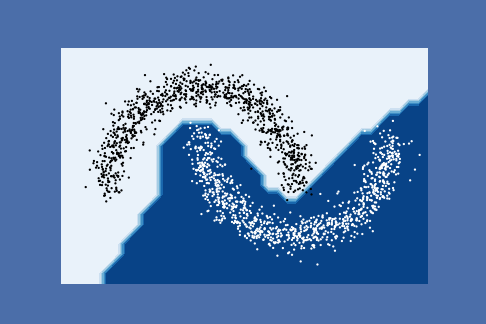

In [18]:
# unfortunately animation is not working on colab
# you should comment the following line if on colab
%matplotlib notebook
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
losses = []
learning_rate = 1e-2
for it in range(10000):
    # pick a random example id
    j = np.random.randint(1, len(X))

    # select the corresponding example and label
    example = X[j:j+1]
    label = Y[j]

    # do a forward pass on the example
    # YOUR CODE HERE
    out = net.forward(example)

    # compute the loss according to your output and the label
    # YOUR CODE HERE
    loss = net.compute_loss(out,label)
    losses.append(loss)
    
    # backward pass
    # YOUR CODE HERE
    net.backward()
    
    # gradient step
    # YOUR CODE HERE
    net.step(learning_rate)
    # draw the current decision boundary every 250 examples seen
    if it % 250 == 0 : 
        plot_decision_boundary(ax, X,Y, net)
        fig.canvas.draw()
plot_decision_boundary(ax, X,Y, net)
fig.canvas.draw()

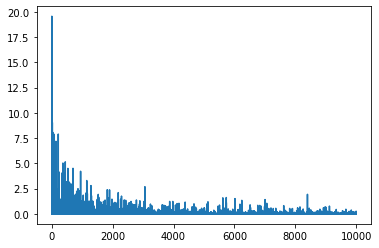

In [19]:
%matplotlib inline
plt.plot(losses)

## 3. Using a Pytorch module

In this last part, use `toch.nn.Module` to recode `MyLinear` and `MyReLU` so that these modules will be pytorch compatible.

In [20]:
import torch
import torch.nn as nn

# y = Wx + b
class MyLinear_mod(nn.Module):
    def __init__(self, n_input, n_output):
        super(MyLinear_mod, self).__init__()
        # define self.A and self.b the weights and biases
        # initialize them with a normal distribution
        # use nn.Parameters
        # YOUR CODE HERE
        self.W = nn.Parameter(torch.nn.init.normal_(torch.empty(n_input, n_output)))
        self.b = nn.Parameter(torch.nn.init.normal_(torch.empty( n_output)))
        self.x =torch.tensor([])

    def forward(self, x):
        # YOUR CODE HERE
        W = self.W
        b = self.b
        return torch.mm(x, W)+ b
class MyReLU_mod(nn.Module):
    def __init__(self):
        super(MyReLU_mod, self).__init__()
        self.mask = None
    def forward(self, x):
        # YOUR CODE HERE
        self.mask = (x <= 0)
        x[self.mask] = 0 
        return x

In [21]:
# the grid for plotting the decision boundary should be now made of tensors.
to_forward = torch.from_numpy(np.array(list(zip(xx.ravel(), yy.ravel())))).float()

In [28]:
h=50

# define your network with nn.Sequential
# use MyLinear_mod, MyReLU_mod and nn.Sigmoid (from pytorch)
# YOUR CODE HERE
net = nn.Sequential(MyLinear_mod(2,h),MyReLU_mod(), 
                    MyLinear_mod(h,1), nn.Sigmoid())

<IPython.core.display.Javascript object>


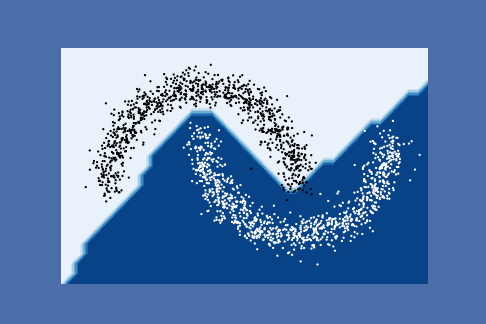

In [29]:
from torch import optim
optimizer = optim.SGD(net.parameters(), lr=1e-2)

X_torch = torch.from_numpy(X).float()
Y_torch = torch.from_numpy(Y).float()

# you should comment the following line if on colab
%matplotlib notebook
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

losses = []
criterion = nn.BCELoss()
for it in range(10000):
    # pick a random example id 
    j = np.random.randint(1, len(X))

    # select the corresponding example and label
    example = X_torch[j:j+1]
    label = Y_torch[j:j+1].unsqueeze(1)

    # do a forward pass on the example
    # YOUR CODE HERE
    output = net(example)
    
    # compute the loss according to your output and the label
    # YOUR CODE HERE
    loss = criterion(output, label)
    losses.append(loss)
    # zero the gradients
    # YOUR CODE HERE
    optimizer.zero_grad()

    # backward pass
    # YOUR CODE HERE
    loss.backward()

    # gradient step
    # YOUR CODE HERE
    optimizer.step()

    # draw the current decision boundary every 250 examples seen
    if it % 250 == 0 : 
        plot_decision_boundary(ax, X,Y, net)
        fig.canvas.draw()
plot_decision_boundary(ax, X,Y, net)
fig.canvas.draw()

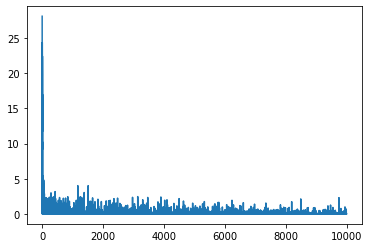

In [30]:
%matplotlib inline
plt.plot(torch.stack(losses, dim=0).detach().numpy())